In [1]:
import tqdm
import pandas as pd
import numpy as np
import neurokit2 as nk
import mne
from mne_icalabel import label_components
mne.set_log_level('WARNING')
from scipy.integrate import simpson # composite Simpson's rule

import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['text.usetex'] = True
plt.rcParams['text.latex.preamble'] = r'''\usepackage{libertine}\usepackage{fontawesome5}\usepackage[dvipsnames]{xcolor}'''
plt.rcParams['ps.usedistiller'] = 'xpdf'
import seaborn as sns
sns.set_theme(style='ticks')

import warnings
warnings.filterwarnings('ignore')

In [2]:
chan_names = ['Fz', 'P3', 'Pz', 'P4', 'PO7', 'Oz', 'PO8']
chan_maps = {
    'Value0': 'Fz',
    'Value1': 'P3',
    'Value2': 'Pz',
    'Value3': 'P4',
    'Value4': 'PO7',
    'Value5': 'Oz',
    'Value6': 'PO8',
}
picks_alpha = ['P3', 'Pz', 'P4']
picks_theta = ['Fz', 'Pz']
picks_beta = ['Fz', 'Pz']

In [3]:

def load_eeg(pid):
    dfEEG = pd.read_csv(f"./data/ID{pid}-EEG.csv")
    dfState = pd.read_csv(f"./data/ID{pid}-state.csv")
    dfEEG.rename(columns=chan_maps, inplace=True)
    dfEEG.drop("TimeLsl", axis =1, inplace=True)
    dfEEG['BlockNumber'] = -1
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][0]) & (dfEEG.Time < dfState['Time'][0+1])].index, 'BlockNumber']   = dfState['BlockNumber'][0]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][2]) & (dfEEG.Time < dfState['Time'][2+1])].index, 'BlockNumber']   = dfState['BlockNumber'][2]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][4]) & (dfEEG.Time < dfState['Time'][4+1])].index, 'BlockNumber']   = dfState['BlockNumber'][4]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][6]) & (dfEEG.Time < dfState['Time'][6+1])].index, 'BlockNumber']   = dfState['BlockNumber'][6]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][8]) & (dfEEG.Time < dfState['Time'][8+1])].index, 'BlockNumber']  = dfState['BlockNumber'][8]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][10]) & (dfEEG.Time < dfState['Time'][10+1])].index, 'BlockNumber'] = dfState['BlockNumber'][10]
    dfEEG.loc[dfEEG[(dfEEG.Time > dfState['Time'][12]) & (dfEEG.Time < dfState['Time'][12+1])].index, 'BlockNumber'] = dfState['BlockNumber'][12]

    dfAll = dfEEG.copy()
    dfAll = dfAll.drop(dfAll[dfAll.BlockNumber < 0].index)
    dfAll = dfAll.dropna()
    dfAll = dfAll.sort_values(by="Time")
    return dfAll

In [4]:
def compute_eeg_feature(group, freqs_range):
    picks = mne.pick_types(group.info, meg=False, eeg=True, eog=False, stim=False)
    psds, freqs = mne.time_frequency.psd_welch(group, proj=False, picks=picks, n_jobs=2, n_per_seg=50, n_overlap=5, n_fft=300)
    idx = np.logical_and(freqs >= freqs_range[0], freqs <= freqs_range[1])
    psds_mean = psds.mean(0)
    freq_res = freqs[1] - freqs[0]
    return simpson(np.log(psds_mean[idx]), dx=freq_res)



def get_block(df, block_number):
    return df[df.BlockNumber == block_number]

def eeg_analysis(df_block, pid):
    info = mne.create_info(ch_names=chan_names, sfreq=250, ch_types='eeg')
    info.set_montage('standard_1020')
    raw = mne.io.RawArray(df_block[chan_names].values.T, info)
    raw_filter = raw.filter(l_freq=1, h_freq=70, fir_design='firwin2')
    raw_filter_notch = raw_filter.notch_filter([50, 100], picks=chan_names, fir_design='firwin')
    raw_filter_notch_ref = raw_filter_notch.set_eeg_reference('average', projection=True)

    ica = mne.preprocessing.ICA(n_components=len(chan_names), random_state=42, max_iter='auto')
    ica.fit(raw_filter_notch_ref)

    ic_labels = label_components(raw_filter_notch_ref, ica, method="iclabel")

    labels = ic_labels["labels"]
    exclude_idx = [idx for idx, label in enumerate(labels) if label not in ["brain", "other"]]

    reconst_raw = raw_filter_notch_ref.copy()
    ica.apply(reconst_raw, exclude=exclude_idx)
    raw_filter_notch_ref_ica = reconst_raw.copy()

    alpha = compute_eeg_feature(raw_filter_notch_ref_ica.copy().pick_channels(picks_alpha), (8, 12))
    theta = compute_eeg_feature(raw_filter_notch_ref_ica.copy().pick_channels(picks_theta), (4, 8))
    beta  = compute_eeg_feature(raw_filter_notch_ref_ica.copy().pick_channels(picks_beta), (12, 25))
    return pid, len(exclude_idx), alpha, theta, beta, raw_filter_notch_ref_ica

In [5]:
pid_valid = list(range(1, 24))
df_all = {}

for pid in tqdm.tqdm(pid_valid):
    if pid == 4 or pid == 8 or pid == 10 or pid == 15 or pid == 16 or pid == 17 or pid == 21:
        continue
    df = load_eeg(pid)
    df_all[pid] = df

100%|██████████| 23/23 [00:18<00:00,  1.23it/s]


In [6]:
df_all[1]

,Time,Fz,P3,Pz,P4,PO7,Oz,PO8,Value7,BlockNumber
49761,1.662020e+09,7002.464,16882.490,-2877.8610,-2876.9580,16887.910,-1930.0150,2208.379,0,1
49788,1.662020e+09,6983.501,16863.530,-2896.8240,-2895.9210,16868.940,-1925.6360,2176.178,0,1
49789,1.662020e+09,6962.732,16842.760,-2917.5930,-2916.6900,16848.170,-1922.7650,2184.292,0,1
49790,1.662020e+09,6964.538,16844.560,-2915.7870,-2914.8840,16849.980,-1898.2160,2187.603,0,1
49791,1.662020e+09,6957.615,16837.640,-2922.7100,-2921.8070,16843.060,-1884.7910,2183.688,0,1
...,...,...,...,...,...,...,...,...,...,...
1313254,1.662024e+09,8300.677,-1579.648,126.3725,575.4442,6773.829,306.3331,1541.601,0,5
1313253,1.662024e+09,8282.015,-1598.310,132.7369,608.3380,6834.813,313.4062,1586.122,0,5
1313269,1.662024e+09,8310.610,-1569.715,159.5228,582.9652,6765.661,289.3340,1566.277,0,5
1313260,1.662024e+09,8297.968,-1582.357,129.0909,611.0251,6812.452,284.7716,1618.623,0,5


In [7]:
df = pd.DataFrame()
for pid in tqdm.tqdm(pid_valid):
    if pid == 4 or pid == 8 or pid == 10 or pid == 15 or pid == 16 or pid == 17 or pid == 21:
        continue
    blocknumbers = df_all[pid].BlockNumber.unique()
    for block_number in blocknumbers:
        df_current = df_all[pid]
        df_current = get_block(df_current, block_number)
        pid, n_ica, alpha, theta, beta, _ = eeg_analysis(df_current, pid)
        df = df.append({
                'pid': pid,
                'n_ica': n_ica,
                'block_number': block_number,
                'alpha': alpha,
                'theta': theta,
                'beta': beta,
            }, ignore_index=True)

100%|██████████| 23/23 [07:22<00:00, 19.26s/it]


In [8]:
df['alpha_theta_ratio'] = df['alpha'] / df['theta']
df['beta_theta_ratio'] = df['beta'] / df['theta']
df.to_csv('processed/eeg_block.csv')

df['alpha_log'] = np.log(df['alpha'])
df['theta_log'] = np.log(df['theta'])
df['beta_log'] = np.log(df['beta'])
df.to_csv('processed/eeg_block.csv')

In [2]:
df = pd.read_csv('processed/eeg_block.csv')

[(0.46988778, 0.58774195, 0.75682037), (0.74094862, 0.77809393, 0.84474951), (0.9805997, 0.96155216, 0.95813083), (0.88153537, 0.72369332, 0.71478461), (0.77636283, 0.46912235, 0.45984473)]


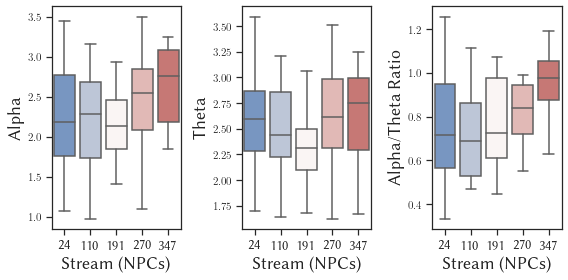

In [5]:
fig, axes = plt.subplots(1, 3, figsize=(8, 4))
colors = sns.color_palette('vlag', n_colors=5)
# colors = sns.color_palette('coolwarm', n_colors=10)
# colors = [colors[0], colors[2], colors[-1]]
print(colors)
sns.boxplot(y='alpha_log', data=df[(df.block_number != 6)&(df.block_number != 7)], ax=axes[0], x='block_number', saturation=1, palette=colors, showfliers=False)
sns.boxplot( y='theta_log', data=df[(df.block_number != 6)&(df.block_number != 7)], ax=axes[1], x='block_number', palette=colors, saturation=1, showfliers=False)
sns.boxplot( y='alpha_theta_ratio', data=df[(df.block_number != 6)&(df.block_number != 7)], ax=axes[2], x='block_number', palette=colors, saturation=1, showfliers=False)

axes[0].set_ylabel('Alpha', fontsize=18)
axes[1].set_ylabel('Theta', fontsize=18)
axes[2].set_ylabel('Alpha/Theta Ratio', fontsize=18)

axes[0].set_xticklabels(['24', '110', '191', '270', '347'], fontsize=14)
axes[1].set_xticklabels(['24', '110', '191', '270', '347'], fontsize=14)
axes[2].set_xticklabels(['24', '110', '191', '270', '347'], fontsize=14)

axes[0].set_xlabel('')
axes[1].set_xlabel('')
axes[2].set_xlabel('')
axes[0].set_xlabel('Stream (NPCs)', fontsize=18)
axes[1].set_xlabel('Stream (NPCs)', fontsize=18)
axes[2].set_xlabel('Stream (NPCs)', fontsize=18)


plt.tight_layout()
plt.savefig('figures/eeg_block.pdf')